# Modelo 2 -  Regresion. Calcular probabilidad de churn

In [2]:
from tensorflow import random as tf_random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_prep import preprocesar

np.random.seed(7)
random.seed(7)
tf_random.set_seed(7)


full_df = pd.read_csv("C:\\ProyectoB_ChurnClientes\\ProyectoB_ChurnClientes\\ProyectoB_ChurnClientes\\data\\raw\\WA_Fn-UseC_-Telco-Customer-Churn.csv")
full_df['TotalCharges'] = pd.to_numeric(full_df['TotalCharges'], errors='coerce')
full_df = full_df.dropna()
full_df = full_df.drop(columns='customerID')
full_df['SeniorCitizen'] = full_df['SeniorCitizen'].astype(str)

X_full = full_df.drop(columns='Churn')
y_full = full_df['Churn']

full_df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Prediccion

### class_weights con las columnas mas correlacionadas

Se inicia probando el rendimiento del modelo eliminando las columnas con poca correlacion con la variable objetivo. Se utiliza la funcion sigmoid para conseguir que la salida sea una probablidad. Ademas, se añade la metrica recall ya que el costo de no detectar a los clientes que puedan dejar el servicio es mucho más alto que un falso positivo.




Epoch 31: early stopping


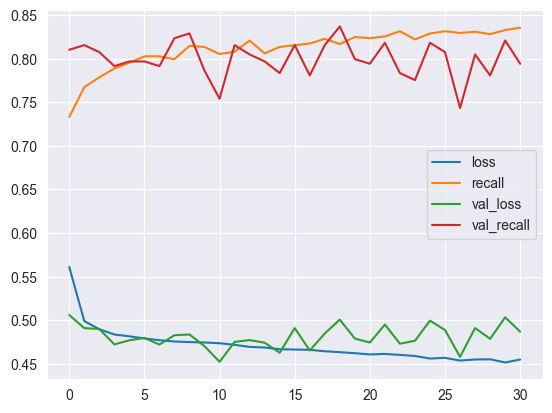

In [3]:
X_train, X_test, y_train, y_test, pipe = preprocesar(
    X_full.drop(columns=['MonthlyCharges', 'SeniorCitizen','Partner','Dependents','PaperlessBilling']),
    y_full
)

model = Sequential()

model.add(Dense(units=X_train.shape[1], activation='relu'))
model.add(Dense(units=int(X_train.shape[1]/2), activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=[Recall(name='recall')],
) 


early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


classes = np.unique(y_train)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, weights))

model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test,y_test),
    class_weight=class_weights,
    verbose=0,
    callbacks=[early_stop],
)

pd.DataFrame(model.history.history).plot();

Se observa un recall y loss con constante varianza debido a las penalizaciones por equivocarse en la clase minoritaria. Ademas, val_loss parece tener una tendencia a subir a pesar del EarlyStoppping y val_recall se encuentra entre 0.75 y 0.85

### Usando Dropout

Epoch 35: early stopping


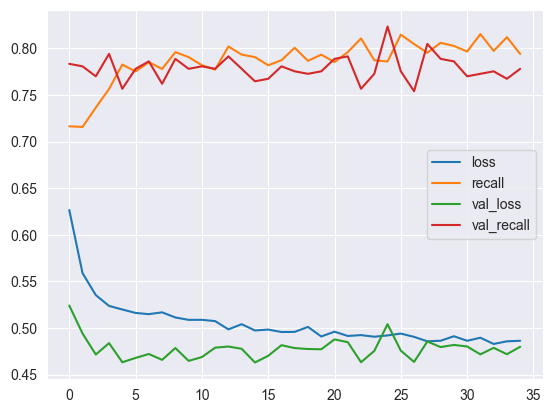

In [4]:
model = Sequential()

model.add(Dense(units=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(units=int(X_train.shape[1]/2), activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=[Recall(name='recall')],
) 

model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test,y_test),
    class_weight=class_weights,
    verbose=0,
    callbacks=[early_stop],
)

pd.DataFrame(model.history.history).plot();

Al usar un Dropout se obtienen resultados muy similares pero con mas epochs

### Reduciendo el learning_rate

Epoch 78: early stopping


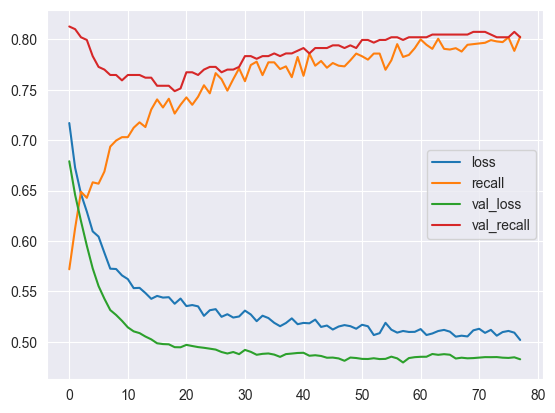

In [5]:
model = Sequential()

model.add(Dense(units=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(units=int(X_train.shape[1]/2), activation='relu'))
model.add(Dropout(0.3)) 
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=[Recall(name='recall')],
) 

model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test,y_test),
    class_weight=class_weights,
    verbose=0,
    callbacks=[early_stop],
)

pd.DataFrame(model.history.history).plot();

Al cambiar el learning_rate se observa claramente como las loss tienen una tendencia a bajar y el recall a subir, lo cual es lo deseado

### Usando SMOTE

Epoch 27: early stopping


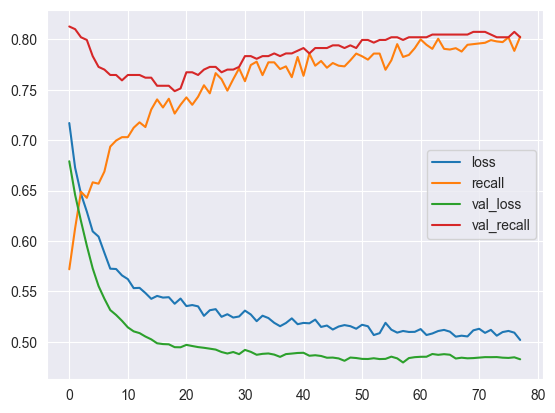

In [6]:
sm = SMOTE(random_state=7)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

model_sm = Sequential()

model_sm.add(Dense(units= X_train.shape[1], activation='relu'))
model_sm.add(Dropout(0.3)) 
model_sm.add(Dense(units=int( X_train.shape[1]/2), activation='relu'))
model_sm.add(Dropout(0.3)) 
model_sm.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=[Recall(name='recall')],
) 


model_sm.compile(optimizer="adam", 
              loss='binary_crossentropy', 
              metrics=[Recall(name='recall')])

model_sm.fit(
    x=X_train_res,
    y=y_train_res,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[early_stop],
)


pd.DataFrame(model.history.history).plot();

Al usar SMOTE se obtiene un resultado practicamente igual

## Evaluacion final

44/44 [==============================] - 0s 602us/step


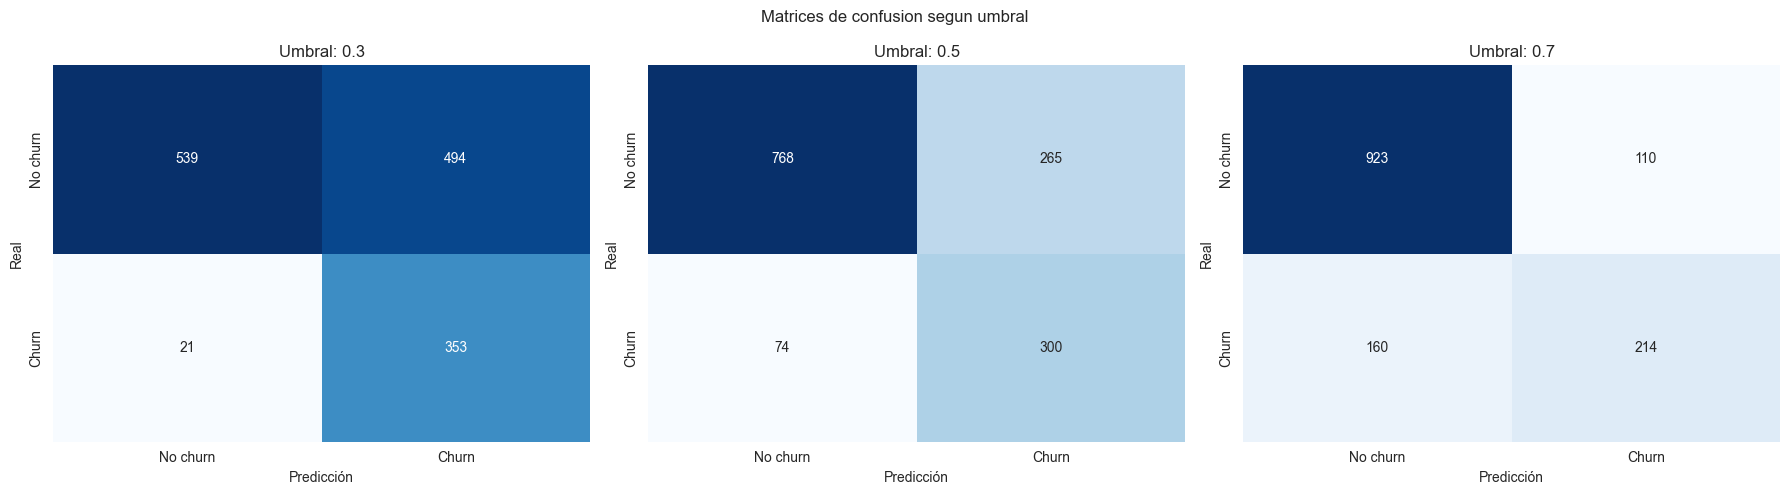

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
umbrales = [0.3, 0.5, 0.7]
predicciones = model.predict(X_test)

for i, threshold in enumerate(umbrales):
    predicciones_binario = (predicciones >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, predicciones_binario)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No churn', 'Churn'], 
                yticklabels=['No churn', 'Churn'],
                ax=axes[i], cbar=False)
    
    axes[i].set_title(f'Umbral: {threshold}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.suptitle('Matrices de confusion segun umbral')
plt.tight_layout()

In [8]:
print(classification_report(y_test, (predicciones >= 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.53      0.80      0.64       374

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407



## Clasificacion por nivel de riesgo y ejemplo de uso

In [9]:
df_prediccion = X_test.copy()
df_prediccion['probabilidad_Churn'] = predicciones
df_prediccion['Churn_real'] = y_test


bins = [0, 0.33, 0.66, 1.0]
labels = ['Bajo', 'Medio', 'Alto']

df_prediccion['nivel_riesgo'] = pd.cut(df_prediccion['probabilidad_Churn'], 
                                      bins=bins, 
                                      labels=labels, 
                                      include_lowest=True)

In [10]:
df_prediccion[['probabilidad_Churn', 'Churn_real','nivel_riesgo']]

,probabilidad_Churn,Churn_real,nivel_riesgo
109,0.007782,0,Bajo
1222,0.044319,0,Bajo
3928,0.753639,0,Alto
6569,0.074949,0,Bajo
4473,0.780320,0,Alto
...,...,...,...
431,0.061795,0,Bajo
6246,0.082579,0,Bajo
778,0.231944,0,Bajo
1489,0.258903,0,Bajo


## Exportar csv y modelos

In [11]:
pd.concat((X_train, y_train), axis=1).to_csv('../data/processed/train-Modelo-2.csv', index=False)
pd.concat((X_test, y_test), axis=1).to_csv('../data/processed/train-Modelo-2.csv',index=False)

In [12]:
model.save('../models/model2.keras')